In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

from itertools import product
import pandas as pd
import torch
import torch.nn.functional as F
from torch_sparse.tensor import SparseTensor
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

from src.train.gcn_node_classifier import GCNNodeClassifierTrainer
from src.torch_geo_models import GCN
from src.data.node_classifier.arxiv import load_dataset_pyg,\
    data_to_sparse_symmetric_pyg, get_edge_weights_pyg

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
weights_source = 'structural_omega_cossim'

### Read metrics

In [4]:
metrics = GCNNodeClassifierTrainer.read_metrics(weights_source=weights_source)
print(metrics.shape)
metrics.head()

(3030, 10)


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
0,1,0,False,1,3.741970,3.737498,3.734182,0.002804,0.001812,0.001955
1,1,50,False,1,3.188882,3.233963,3.262270,0.185032,0.182355,0.176429
2,1,100,False,1,2.976256,3.030072,3.065616,0.220693,0.168395,0.152028
3,1,150,False,1,2.837870,2.902633,2.946209,0.252823,0.231048,0.212477
4,1,200,False,1,2.722807,2.798740,2.850033,0.284272,0.282593,0.260457


## Selected model results

For each configuration we select a model based on the validation accuracy and compare on the test nodes.

In [5]:
def get_best_metrics(keys_df: pd.DataFrame):
    return keys_df.sort_values('acc_val', ascending=False).iloc[0]

best_epoch_metrics = metrics\
    .groupby(['run', 'n_layers', 'has_edge_weights'])\
    .apply(get_best_metrics)\
    .reset_index(drop=True)

print(best_epoch_metrics.shape)
print(best_epoch_metrics['run'].max())
best_epoch_metrics.tail()

(30, 10)
5


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
25,5,9450,True,1,1.208284,1.175320,1.149445,0.651576,0.661096,0.662387
26,5,2300,False,2,0.651183,0.896970,0.931223,0.791513,0.723246,0.715347
27,5,2000,True,2,0.840273,1.094829,1.084594,0.752213,0.694554,0.696089
28,5,1800,False,3,0.567849,0.860679,0.906543,0.811295,0.733280,0.715717
29,5,1650,True,3,0.813395,1.043351,1.050196,0.760009,0.698748,0.699772


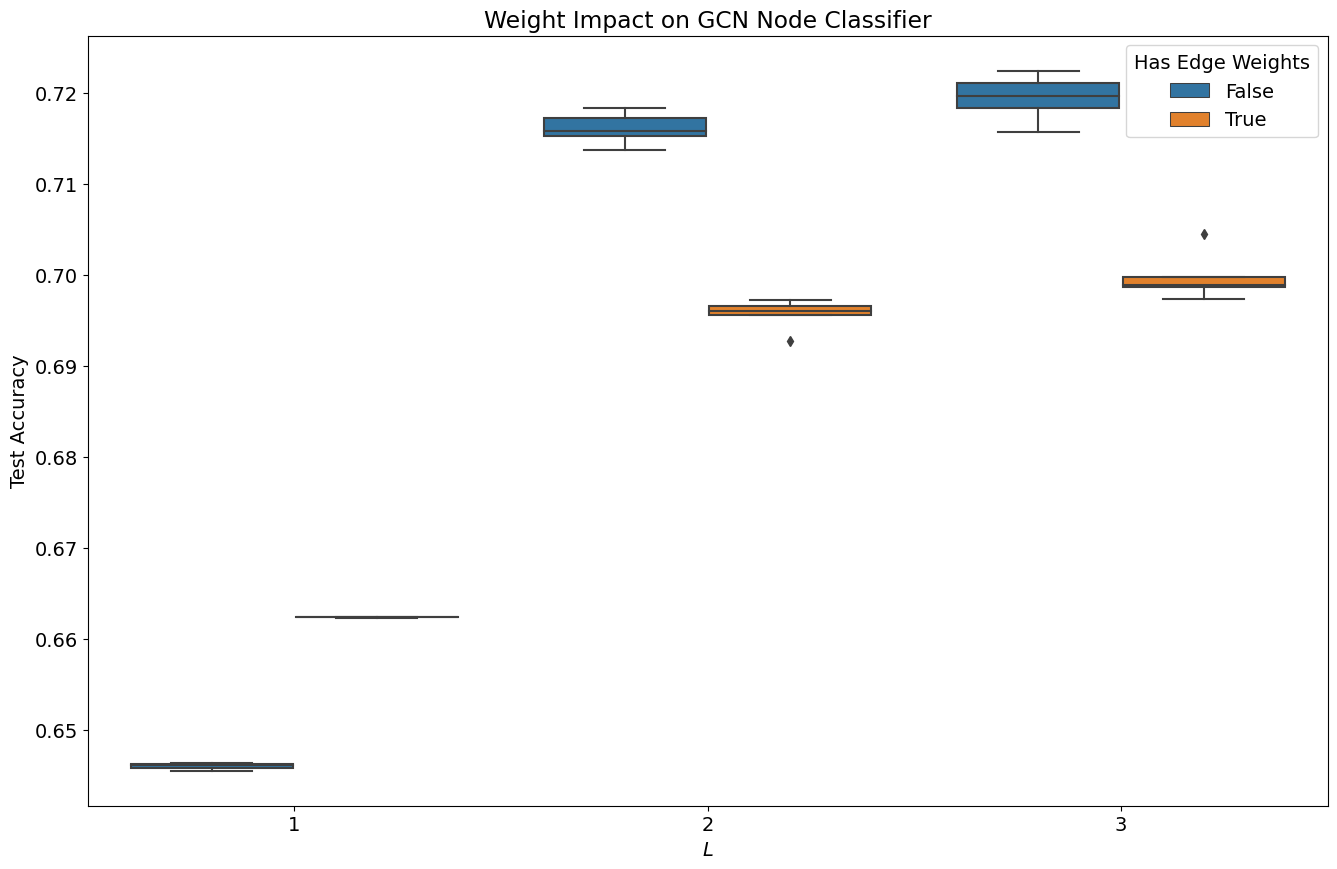

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

plt.title('Weight Impact on GCN Node Classifier')

sns.boxplot(
    data=best_epoch_metrics,
    x='n_layers',
    y='acc_test',
    hue='has_edge_weights')

plt.ylabel('Test Accuracy')
plt.xlabel('$L$')


# plt.yscale('log')
plt.legend(title='Has Edge Weights')
plt.savefig('reports/images/structural_graph_sage_cossim_weight_impact_gcn_node_classifier.pdf')

## T-test

In [7]:
report = {
    '$L$': [],
    'Weighted': [],
    'Unweighted': [],
    '$t$': [],
    'p-value': []
}

for n_layers in range(1, 4):
    a = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == True')\
        ['acc_test']
        
    b = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == False')\
        ['acc_test']
    ttest = ttest_ind(a, b)
    
    report['$L$'].append(f'${n_layers}$')
    report['Weighted'].append(f'${a.mean():.4} \pm {a.std():.2}$')
    report['Unweighted'].append(f'${b.mean():.4} \pm {b.std():.2}$')
    report['$t$'].append(f'${ttest.statistic:.4}$')
    report['p-value'].append(f'${ttest.pvalue:.4}$')
    
    
    print(f'with: {a.mean():.4} +- {a.std():.2}, '
          f'no: {b.mean():.4} +- {b.std():.4}, '
          f't: {ttest.statistic:.4}, pvalue: {ttest.pvalue:.4}')

with: 0.6624 +- 4.6e-05, no: 0.646 +- 0.0003608, t: 100.7, pvalue: 1.057e-13
with: 0.6957 +- 0.0017, no: 0.7161 +- 0.001778, t: -18.45, pvalue: 7.682e-08
with: 0.6998 +- 0.0027, no: 0.7195 +- 0.002608, t: -11.64, pvalue: 2.701e-06


In [8]:
print(pd.DataFrame(report).style.to_latex())

\begin{tabular}{llllll}
 & $L$ & Weighted & Unweighted & $t$ & p-value \\
0 & $1$ & $0.6624 \pm 4.6e-05$ & $0.646 \pm 0.00036$ & $100.7$ & $1.057e-13$ \\
1 & $2$ & $0.6957 \pm 0.0017$ & $0.7161 \pm 0.0018$ & $-18.45$ & $7.682e-08$ \\
2 & $3$ & $0.6998 \pm 0.0027$ & $0.7195 \pm 0.0026$ & $-11.64$ & $2.701e-06$ \\
\end{tabular}



## Epochs comparison

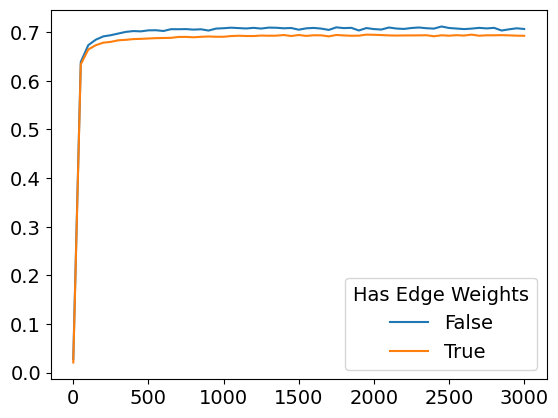

In [15]:
n_layers = 2
col = 'acc_test'

sub_df = metrics.query(f'n_layers == {n_layers}')

no_means = sub_df\
    .query('has_edge_weights == False')\
    .groupby('epoch')\
    [col]\
    .mean()

w_means = sub_df\
    .query('has_edge_weights == True')\
    .groupby('epoch')\
    [col]\
    .mean()

plt.plot(no_means, label='False')
plt.plot(w_means, label='True')

plt.legend(title='Has Edge Weights')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(200)
# plt.ylim(0.65, 0.75)